<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/345_bayesian_prediction.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(bayesian_prediction_notebook)=
# La predizione bayesiana

L'analisi bayesiana ha diversi obiettivi chiave, che includono la formulazione della distribuzione a posteriori dei parametri, la valutazione delle ipotesi e la previsione di dati futuri. Una volta determinate le distribuzioni a posteriori dei parametri, si può procedere a formulare stime riguardo alle possibili caratteristiche di dati futuri. Questo processo porta alla creazione di una *distribuzione predittiva a posteriori*, che serve come strumento essenziale per la verifica e la validazione del modello statistico in uso. Questa distribuzione predittiva permette un confronto diretto tra le previsioni generate dal modello e i dati che sono stati effettivamente osservati nel campione. In pratica, utilizziamo il modello corrente per generare previsioni sui possibili dati futuri e poi confrontiamo queste previsioni con i dati che abbiamo effettivamente raccolto. Se le previsioni generate dal modello sono in buon accordo con i dati osservati, possiamo concludere che il modello fornisce una rappresentazione accurata dei dati.

Una seconda forma di predizione bayesiana riguarda la distribuzione predittiva a priori (*prior predictive distribution*). La distribuzione predittiva a priori rappresenta la distribuzione dei possibili dati osservabili prima di aver effettivamente osservato qualsiasi dato. Essa incorpora la nostra conoscenza a priori, o le nostre credenze iniziali, riguardo ai parametri del modello.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 
import pymc as pm
import pymc.sampling_jax
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
sns.set_palette("colorblind")

## La Distribuzione Predittiva Posteriore

Per illustrare il concetto di "distribuzione predittiva a posteriori", consideriamo un esempio specifico: il modello beta-binomiale. In questo scenario, il parametro $\theta$ (che rappresenta la probabilità di successo) segue una distribuzione a priori modellata come una distribuzione Beta. La verosimiglianza dei dati è descritta da una distribuzione Binomiale. I dati sono rappresentati dal numero $y$ di successi in $n$ prove Bernoulliane indipendenti.

Prendiamo in considerazione un esempio discusso in precedenza, relativo al numero di artisti della generazione X o successive rappresentati al MOMA. In un campione di 100 artisti, abbiamo osservato che solamente 14 di essi appartengono a tali generazioni. Di conseguenza, possiamo parlare di 14 "successi" in 100 prove Bernoulliane indipendenti. Supponiamo ora di voler esaminare un nuovo campione casuale composto da $m$=20 artisti all'interno del MOMA. L'obiettivo è stimare quanti di essi apparterranno alla generazione X o successive. In generale, vogliamo formulare delle previsioni riguardanti i risultati di nuovi campioni potenziali costituiti da $m$ osservazioni.

Definiamo una variabile casuale $\tilde{Y}$ che rappresenta il numero di "successi" in un nuovo campione di $m$ prove. Quindi, in un nuovo campione, $\tilde{Y}$ può assumere valori come $\tilde{y}_1$ (ad esempio, 12), $\tilde{y}_2$ (ad esempio, 7), e così via. L'obiettivo consiste nel calcolare le probabilità associate a ciascuno dei valori possibili di $\tilde{Y}$, compresi tra 0 e 20 inclusi. Questa distribuzione di probabilità discreta prende il nome di "distribuzione predittiva a posteriori", $p(\tilde{Y} = \tilde{y} \mid Y = y)$, ed esprime la probabilità attribuita a ciascuno dei possibili valori di $\tilde{Y}$ (0, 1, ..., 19, 20) nei futuri campioni potenziali costituiti da $m$ = 20 osservazioni.

In questo capitolo, esamineremo tre diverse strategie per conseguire questo obiettivo:

1. **Approccio analitico**: Risolveremo la distribuzione attraverso metodi matematici.
2. **Simulazione**: Utilizzeremo tecniche di simulazione per ottenere i risultati desiderati.
3. **Campionamento MCMC**: Applicheremo il metodo di campionamento MCMC per stimare la distribuzione predittiva a posteriori.

Tutti e tre i metodi risultano equivalenti e conducono agli stessi risultati. Tuttavia, è importante notare che l'approccio MCMC ci consente di ottenere la soluzione in maniera diretta, specialmente quando non è disponibile una soluzione analitica, come accade in casi al di fuori del contesto delle famiglie coniugate.

### Derivazione analitica

Nel contesto in esame, la variabile casuale $ \tilde{Y} $ è governata da una distribuzione che dipende dal parametro $ \theta $. Le informazioni relative a $ \theta $ sono contenute nella distribuzione a posteriori $ p(\theta | y) $. Utilizzando la regola della probabilità congiunta, la distribuzione congiunta delle variabili $ \tilde{y} $ e $ \theta $ può essere rappresentata come:

$$
p(\tilde{y}, \theta | y) = p(\tilde{y} | \theta, y) p(\theta | y).
$$

La distribuzione $ p(\tilde{y}, \theta | y) $ descrive la probabilità congiunta di osservare dati futuri $ \tilde{y} $ e un valore specifico del parametro $ \theta $, dati i dati storici $ y $. Si scompone in due parti:

1. $ p(\tilde{y} | \theta, y) $: la probabilità di osservare $ \tilde{y} $ dato un valore specifico di $ \theta $ e i dati storici $ y $.
2. $ p(\theta | y) $: la distribuzione a posteriori di $ \theta $, che rappresenta una versione aggiornata della nostra conoscenza su $ \theta $ dopo aver osservato i dati $ y $.

Se assumiamo che le osservazioni passate $ y $ e le future $ \tilde{y} $ siano indipendenti, condizionate al valore di $ \theta $, la formula si semplifica in:

$$
p(\tilde{y}, \theta | y) = p(\tilde{y} | \theta) p(\theta | y).
$$

Per ottenere la distribuzione predittiva a posteriori $ p(\tilde{y} | y) $, è necessario integrare la distribuzione congiunta rispetto a $ \theta $. Questo passaggio è noto come "marginalizzazione" e serve a eliminare la dipendenza da $ \theta $:

$$
p(\tilde{y} | y) = \int p(\tilde{y} | \theta) p(\theta | y) \, d\theta.
$$

Nel caso del modello beta-binomiale, $ p(\tilde{y} | \theta) $ è una distribuzione binomiale con parametri $ m $ e $ \theta $, mentre $ p(\theta | y) $ è una distribuzione Beta con parametri $ \alpha + y $ e $ \beta + n - y $.

L'integrazione può essere risolta esplicitamente, data la forma funzionale delle distribuzioni Beta e Binomiale. Il risultato è una formula chiusa per $ p(\tilde{y} | y) $, che rappresenta una distribuzione beta-binomiale.

$$
\begin{align*}
p(\tilde{y} | y) &= \int_0^1 p(\tilde{y} | \theta) p(\theta | y) \, d\theta \\
&= \int_0^1 \binom{m}{\tilde{y}} \theta^{\tilde{y}} (1 - \theta)^{m - \tilde{y}} \cdot \frac{1}{B(\alpha + y, \beta + n - y)} \theta^{\alpha + y - 1} (1 - \theta)^{\beta + n - y - 1} \, d\theta \\
&= \binom{m}{\tilde{y}} \frac{B(\tilde{y} + \alpha + y, \beta + n - y + m - \tilde{y})}{B(\alpha + y, \beta + n - y)}
\end{align*}
$$

In conclusione, nel contesto del modello beta-binomiale, la distribuzione predittiva a posteriori è una distribuzione beta-binomiale con parametri $ m $, $ \alpha + y $, e $ \beta + n - y $:

$$
\begin{equation}
f(\tilde{y} | y) = \binom{m}{\tilde{y}} \frac{B(\alpha + y + \tilde{y}, \beta + n - y + m - \tilde{y})}{B(\alpha + y, \beta + n - y)}.
\end{equation}
$$ (eq-beta-binomial-distr)

È importante notare che, se il nostro modello è ben specificato, la distribuzione predittiva a posteriori e la distribuzione dei dati osservati dovrebbero somigliarsi, entrambe governate dalla stessa funzione di densità di probabilità (PDF). Per verificarlo, è comune eseguire dei "controlli predittivi a posteriori", confrontando la distribuzione predittiva a posteriori con i dati osservati.

Un metodo comune per tale confronto implica l'uso delle Stime di Densità del Kernel (KDE, Kernel Density Estimates). Un KDE è essenzialmente una stima empirica della PDF di una variabile casuale basata su un insieme finito di campioni. Confrontando i KDE dei dati osservati e i campioni dalla distribuzione predittiva a posteriori, possiamo valutare quanto bene il nostro modello renda conto dei dati e, quindi, la sua adeguatezza per effettuare previsioni future.

#### Un esempio concreto

Nell'esempio relativo agli artisti del MOMA, la verosimiglianza dei dati segue una distribuzione binomiale, con 14 successi su 100 prove. La distribuzione a priori per il parametro di successo $\theta$ è una distribuzione Beta(4, 6). Di conseguenza, la distribuzione a posteriori sul parametro $\theta$ è una distribuzione Beta(18, 92).

L'obiettivo che ci poniamo è calcolare la distribuzione predittiva a posteriori per un nuovo campione con un numero di osservazioni $m$ = 20.

Con riferimento all'eq. {eq}`eq-beta-binomial-distr`, sappiamo che la distribuzione predittiva a posteriori assume la forma di una distribuzione beta-binomiale con i parametri $m$, $\alpha + y$ e $\beta + n - y$. Qui, $m$ denota il numero di prove nel nuovo campione, $\alpha$ e $\beta$ rappresentano i parametri della distribuzione a priori, mentre $y$ e $n$ indicano rispettivamente il numero di successi e il numero totale di prove nel campione attuale. Nell'esempio in esame, otteniamo i seguenti valori per i parametri della distribuzione beta-binomiale: $m = 20$, $\alpha' = 4 + 14 = 18$, $\beta' = 6 + 100 - 14 = 92$.

Possiamo rappresentare graficamente la distribuzione predittiva a posteriori che abbiamo definito usando la funzione `betabinom.pmf`.

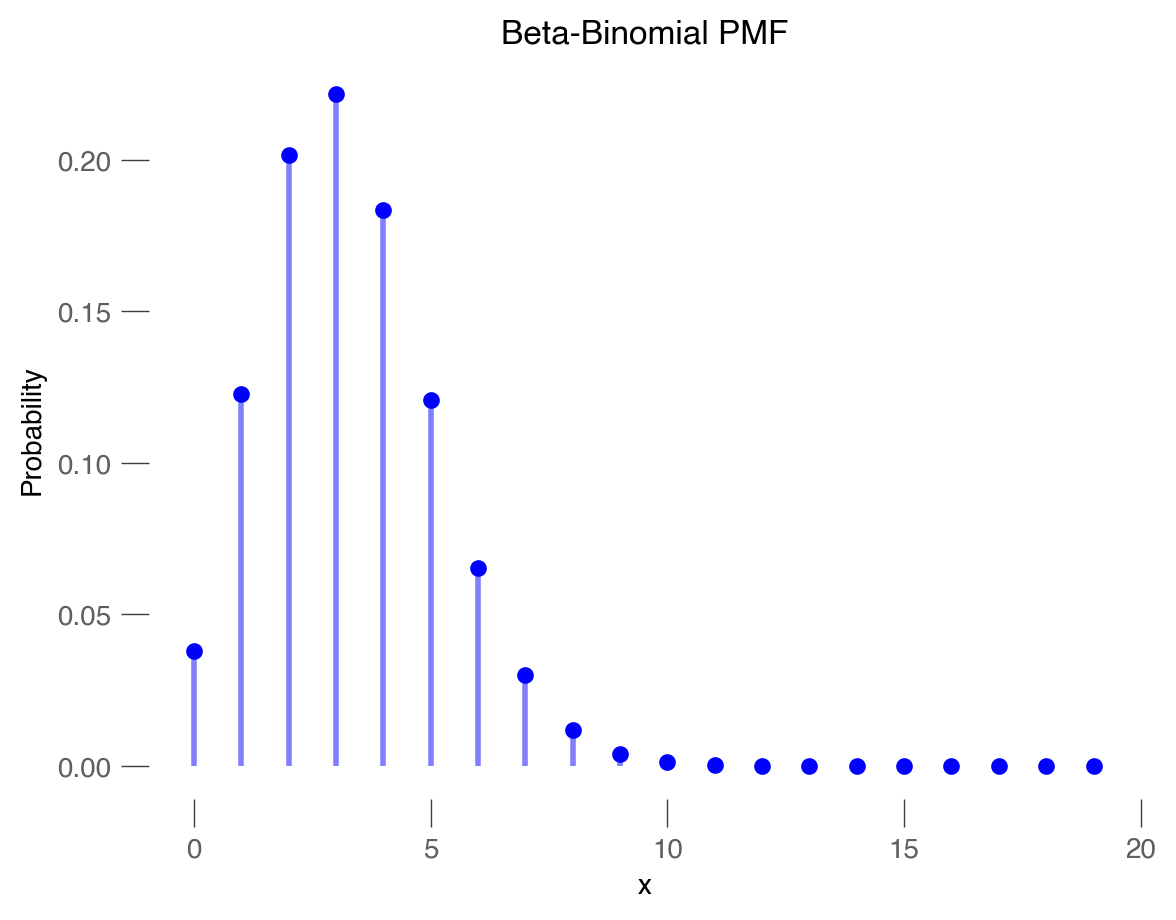

In [3]:
alpha = 4
beta = 6
y = 14
n = 100
alpha_prime = alpha + y
beta_prime = beta + n - y
m = 20
x = np.arange(0, 20)

plt.plot(
    x,
    stats.betabinom.pmf(x, m, alpha_prime, beta_prime),
    "bo",
    ms=5,
    label="betabinom pmf",
)
_ = plt.vlines(
    x,
    0,
    stats.betabinom.pmf(x, m, alpha_prime, beta_prime),
    colors="b",
    lw=2,
    alpha=0.5,
)

# Set x-ticks to be every 5 units
plt.xticks(np.arange(0, 21, 5))

plt.xlabel("x")
plt.ylabel("Probability")
plt.title("Beta-Binomial PMF");

La distribuzione predittiva a posteriori, mostrata nella figura precedente, fornisce informazioni sulla probabilità di osservare $0, 1, \dots, 20$ successi su $m = 20$ prove in un futuro campione di $m$ = 20 osservazioni. Queste probabilità sono valutate tenendo conto dei dati osservati nel campione corrente (14 successi su 100 prove) e delle nostre opinioni iniziali sulla plausibilità dei possibili valori di $\theta$ (rappresentate dalla distribuzione a priori Beta(4, 6)). In altre parole, la distribuzione predittiva a posteriori ci offre una visione delle possibili frequenze di successo che potremmo osservare nei futuri campioni, basandoci sulle nostre conoscenze attuali e sull'esperienza passata.

La distribuzione predittiva a posteriori rivela che, nei potenziali campioni futuri composti da 20 osservazioni, il valore $\tilde{y}$ con la probabilità più elevata è 3. Tuttavia, la distribuzione predittiva a posteriori ci fornisce informazioni sulla probabilità relativa di ciascuno dei possibili valori futuri di $\tilde{y}$. Questi valori rappresentano il numero di artisti della Generazione X o successive che potrebbero trovarsi all'interno di un futuro campione di 20 osservazioni.

Una volta ottenuta la distribuzione predittiva a posteriori possiamo rispondere a ulteriori domande. Ad esempio, Qual è la probabilità a posteriori che almeno 5 degli 20 artisti siano della generazione X, ossia $P(\tilde{Y} \geq 5 \mid Y = 14)$?

Il risultato è dato da $\sum_i(P(\tilde{Y} = \tilde{y}_i)$, con $i \in 5, \dots, 20$.

In [4]:
1 - stats.betabinom.cdf(4, m, alpha_prime, beta_prime).sum()

0.23298739435887628

È altresì possibile calcolare il valore atteso della distribuzione predittiva a posteriori, cioè il numero previsto di artisti appartenenti alla Generazione X o successiva in un campione casuale di 20.

In [5]:
x = np.arange(0, 21)
px = stats.betabinom.pmf(np.arange(0, 21), m, alpha_prime, beta_prime)

ev = sum(x * px)
print(ev)

3.272727272727284


In conclusione, per il caso beta-binomiale, possiamo affermare che la previsione bayesiana di una nuova osservazione futura è rappresentata dalla distribuzione beta-binomiale con parametri $m$, $\alpha + y$ e $\beta + n - y$. Qui, $m$ rappresenta il numero di prove nel nuovo campione, $\alpha$ e $\beta$ sono i parametri della distribuzione a priori, e $y$ e $n$ sono le caratteristiche del campione attuale. In altre parole, la distribuzione beta-binomiale ci fornisce una stima delle possibili frequenze di successi che potremmo osservare in futuri campioni, tenendo conto dei dati osservati e delle nostre conoscenze iniziali sulla probabilità di successo.

### Metodo basato sulla simulazione

In situazioni in cui non è possibile ottenere esattamente la distribuzione predittiva a posteriori, è comunque possibile ottenere un campione casuale di valori dalla distribuzione mediante simulazione. Nel caso in esame, supponiamo di voler generare un campione casuale di $n$ osservazioni dalla distribuzione predittiva a posteriori. Per farlo, possiamo seguire due fasi di simulazione:

1. Estraiamo casualmente $n$ valori del parametro $\theta$ dalla distribuzione a posteriori $p(\theta \mid y)$.
2. Utilizziamo i valori del parametro $\theta$ estratti per generare $n$ valori casuali di $\tilde{y}$, utilizzando il modello binomiale con i parametri $m$ e $\theta_i$ (con $i = 1, \dots, n$).

In questo modo, otteniamo $n$ realizzazioni casuali di $n$ distribuzioni binomiali, ciascuna con i parametri specificati sopra, le quali rappresentano un campione casuale di valori della distribuzione predittiva a posteriori.

Vediamo come ottenere questo risultato in pratica. Per l'esempio che stiamo discutendo, la distribuzione a posteriori di $\theta$ è una Beta(25, 17). Procediamo con l'estrazione casuale di 100,000 valori da questa distribuzione e esaminiamo i primi 10 valori:

In [6]:
nrep = 100000
theta = stats.beta.rvs(alpha_prime, beta_prime, size=nrep)
print(*theta[0:10])

0.17719721744186548 0.13291370792578444 0.1280571914296196 0.08703057221554174 0.1602942530234538 0.1657917575000183 0.2005712014143028 0.1685769554184571 0.17917543082009346 0.1659406593065688


Per ciascuno dei 100,000 valori estratti per $\theta$, generiamo casualmente un valore dalla distribuzione binomiale con parametri $n = 20$ e probabilità $\theta$. Esaminiamo i primi 50 valori così ottenuti.

In [7]:
y_tilde = [stats.binom.rvs(n=20, p=th, size=1) for th in theta]
y_tilde = np.concatenate(y_tilde)
print(*y_tilde[0:50])

4 5 3 0 4 4 4 4 4 0 6 0 3 9 2 5 0 1 3 5 3 7 6 3 6 1 3 2 3 3 3 6 3 4 3 4 2 8 7 1 3 1 6 4 3 7 6 6 3 4


L'insieme dei valori `y_tilde` costituisce un campione casuale dalla distribuzione predittiva a posteriori. Nella figura seguente, è presentato un istogramma che mostra la distribuzione dei valori `y_tilde`. I punti corrispondenti alla distribuzione predittiva a posteriori corretta, ossia una distribuzione Beta-Binomiale con parametri $m = 20$, $\alpha' = 18$, e $\beta' = 92$, sono sovrapposti sull'istogramma. Si può notare una quasi perfetta concordanza tra i valori ottenuti tramite la simulazione e quelli ricavati con la derivazione analitica.

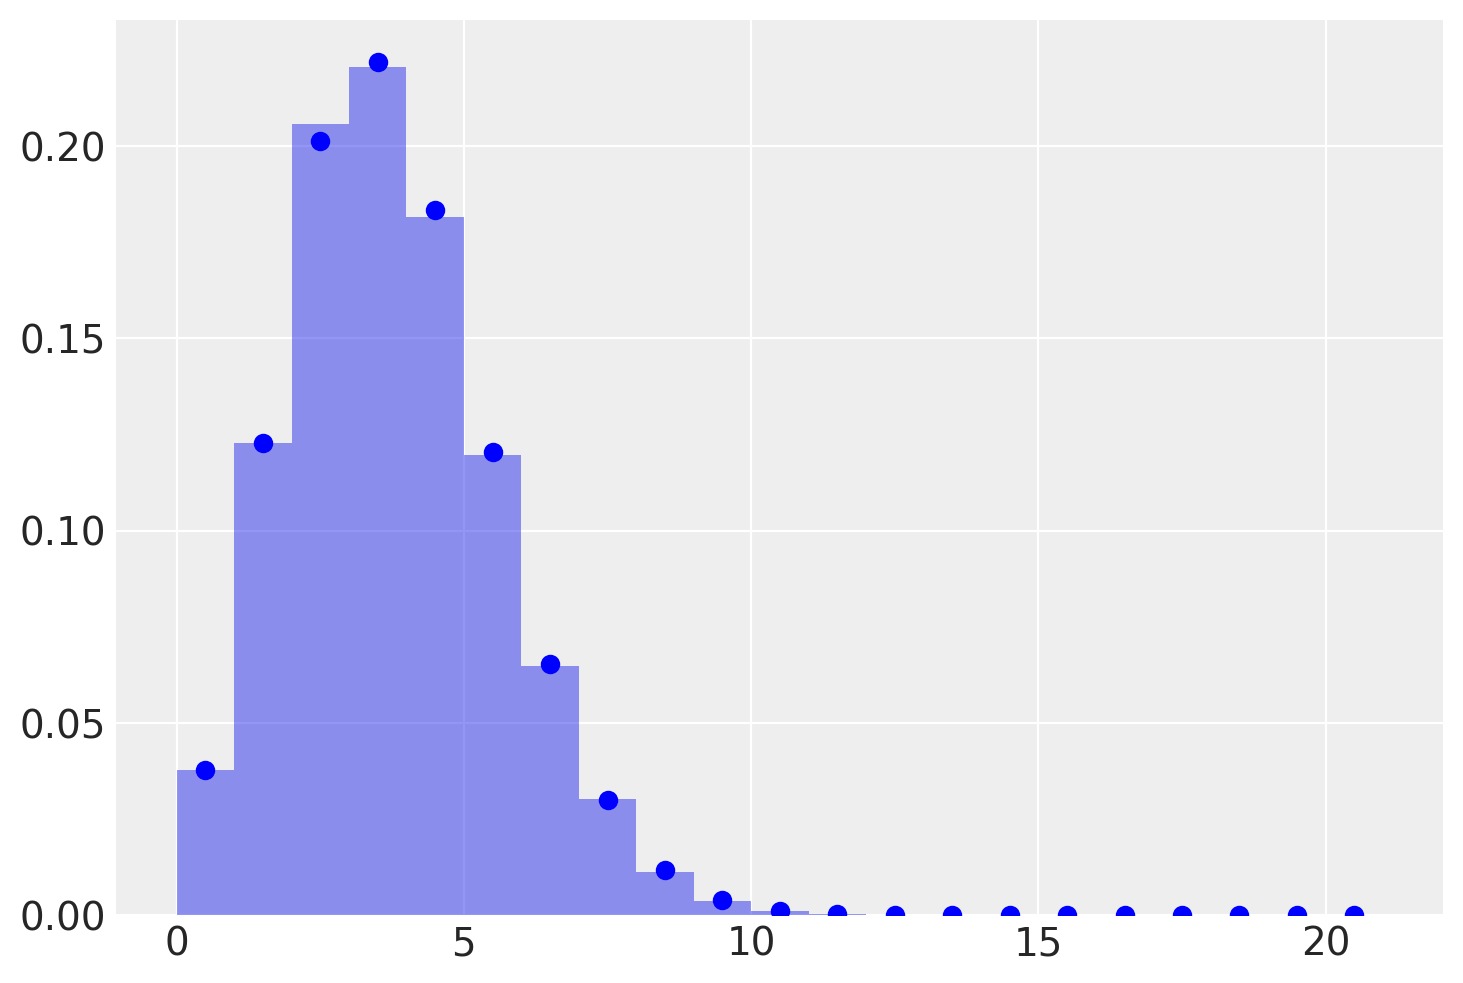

In [8]:
hist, bins, _ = plt.hist(y_tilde, bins=range(0, 22), density=True, alpha=0.5)
bin_centers = (bins[:-1] + bins[1:]) / 2
px = stats.betabinom.pmf(np.arange(0, 21), m, alpha_prime, beta_prime)
plt.plot(bin_centers, px, "o", color="blue", label="Beta-Binomial");

Un intervallo di credibilità all'80% si può facilmente ottenere usando ArviZ.

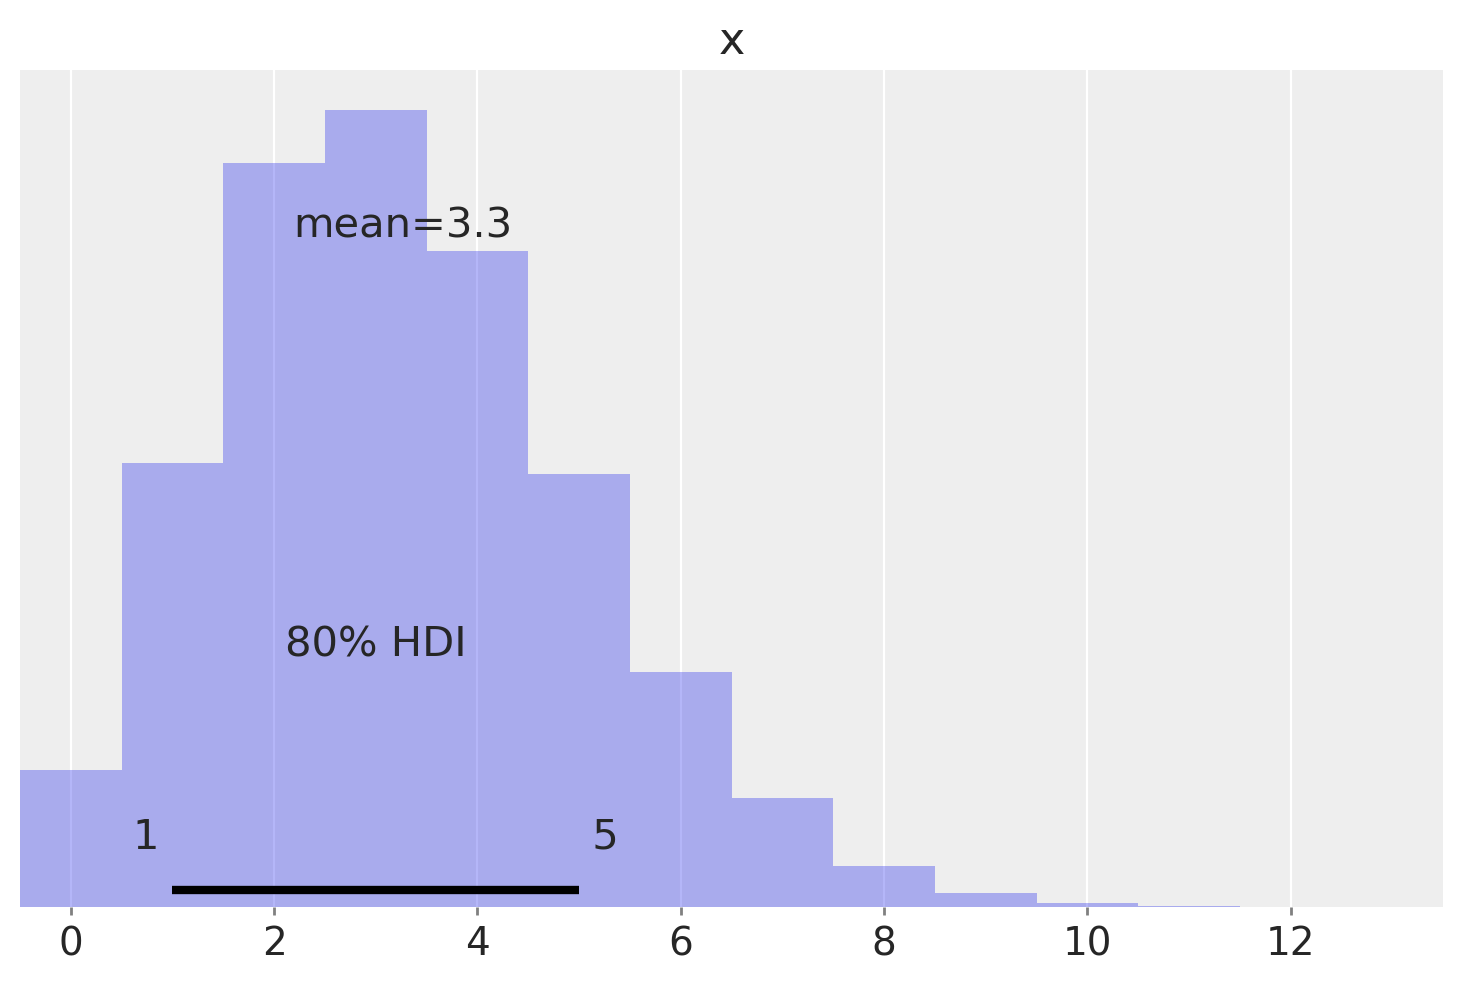

In [9]:
az.plot_posterior(y_tilde, hdi_prob=0.8, kind="kde", bw=0.5);

Possiamo concludere affermando che, nel caso in cui analizzassimo un nuovo campione di 20 artisti provenienti dal MOMA, ci potremmo attendere che solamente 3 di questi artisti facciano parte della generazione X o di una generazione successiva. Tuttavia, è importante sottolineare che questa stima è soggetta a un certo grado di incertezza. Considerando un livello di fiducia soggettivo dell'80%, l'intervallo di variabilità stimato va da un minimo di 1 ad un massimo di 5 artisti, che potrebbero essere rappresentativi di queste generazioni successive. 

## Metodo MCMC

Il metodo di simulazione discusso sopra segue la stessa logica utilizzata dai metodi MCMC per ottenere un'approssimazione della distribuzione predittiva a posteriori. Mediante i metodi MCMC, vengono stimate le possibili osservazioni future $p(\tilde{y} \mid y)$, rappresentate come $p(y^{rep} \mid y)$, attraverso i seguenti passaggi:

1. Campionare $\theta_i \sim p(\theta \mid y)$: Viene selezionato casualmente un valore del parametro dalla distribuzione a posteriori.
2. Campionare $y^{rep} \sim p(y^{rep} \mid \theta_i)$: Viene selezionata casualmente un'osservazione dalla funzione di verosimiglianza, condizionata al valore del parametro ottenuto nel passo precedente.

Ripetendo questi due passaggi un numero sufficiente di volte, l'istogramma risultante approssimerà la distribuzione predittiva a posteriori. In alcuni casi, come nel presente esempio, è possibile ottenere analiticamente la distribuzione predittiva a posteriori. In altre situazioni, invece, l'utilizzo dei metodi MCMC consente di ottenere un'approssimazione accurata della distribuzione predittiva a posteriori quando una derivazione analitica non è possibile.

Esaminiamo ora come ottenere la distribuzione predittiva a posteriori con PyMC per i dati dell'esempio. Iniziamo a creare la distribuzione a posteriori di $\theta$.

In [3]:
ntrials = 100
y = 14

alpha_prior = 4
beta_prior = 6

with pm.Model() as model:
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)

In [6]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:01.139417
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:02<?, ?it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 759.40it/s]

Sampling time =  0:00:02.986635
Transforming variables...
Transformation time =  0:00:00.027150


In [7]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.163,0.035,0.101,0.229,0.001,0.001,1523.0,1969.0,1.0


Il processo della simulazione descritta in precedenza può essere automatizzato usando PyMC, ma solo per un campione futuro avente la stessa ampiezza del campione presente ($n = m$ = 100). Le istruzioni necessarie per generare la distribuzione predittiva a posteriori, $y^{rep} \sim p(y^{rep} \mid \theta_i)$ sono fornite di seguito.

In [8]:
with model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [obs]


Esaminiamo il risultato ottenuto.

In [41]:
post_pred.posterior_predictive.obs

<xarray.DataArray 'obs' (chain: 4, draw: 1000)>
array([[19, 19, 19, ...,  9, 17, 11],
       [16, 14, 21, ..., 22, 19, 11],
       [ 7,  9,  9, ..., 13, 12, 16],
       [15, 10, 23, ..., 16, 19, 17]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

Creiamo un istogramma con i dati $y^{rep}$. L'intervallo di credibilità dell'80% è [8, 21].

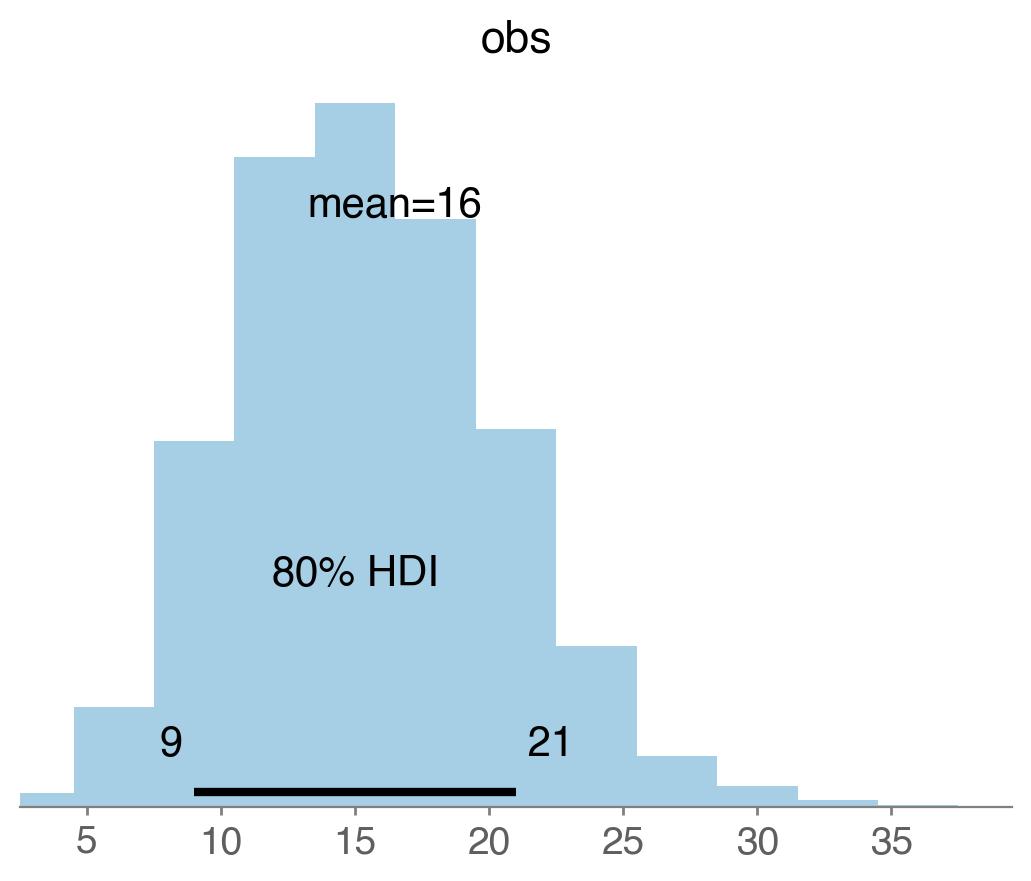

In [42]:
az.plot_posterior(post_pred.posterior_predictive.obs, hdi_prob=0.8)
plt.show()

Se invece vogliamo una distribuzione predittiva a posteriori nel caso di $m$ = 20 dobbiamo procedere svolgendo i calcoli "manualmente".

Il modello predittivo a posteriori riflette due fonti di variabilità:

- la prima fonte di variabilità riguarda la varianza della distribuzione binomiale $\tilde{Y} \mid \pi \sim \text{Binomiale}(20, \pi)$;
- la seconda fonte di variabilità riguarda l'incertezza su $\pi$ che è espressa dalla distribuzione a posteriori di questo parametro.

Per considerare entrambe le fonti di variabilità nelle previsioni a posteriori di $\tilde{Y}$, possiamo impiegare `stats.binom.rvs` per simulare un singolo risultato $\tilde{Y}$ dalla distribuzione Binomiale(20, $\theta$) per ciascuno dei 4000 valori nella catena di Markov relativa a $\theta$.

Iniziamo combinando catene e iterazioni della catena di Markov in un unico vettore.

In [43]:
post = az.extract(idata)
post["theta"].size

4000

Generiamo poi un valore casuale dalla distribuzione Binomiale di parametri $n$ = 20 e $\theta$, per ciascuno dei 4000 valori $\theta$ della distribuzione a posteriori. Il vettore così risultante sarà un campione dalla distribuzione predittiva a posteriori, nel caso di un'ampiezza campionaria pari a 20.

In [46]:
y_rep = stats.binom.rvs(n=20, p=post["theta"])

Usiamo ArviZ per creare un istogramma della distribuzione di `y_rep` e per trovare l'intervallo di credibilità all'80%.

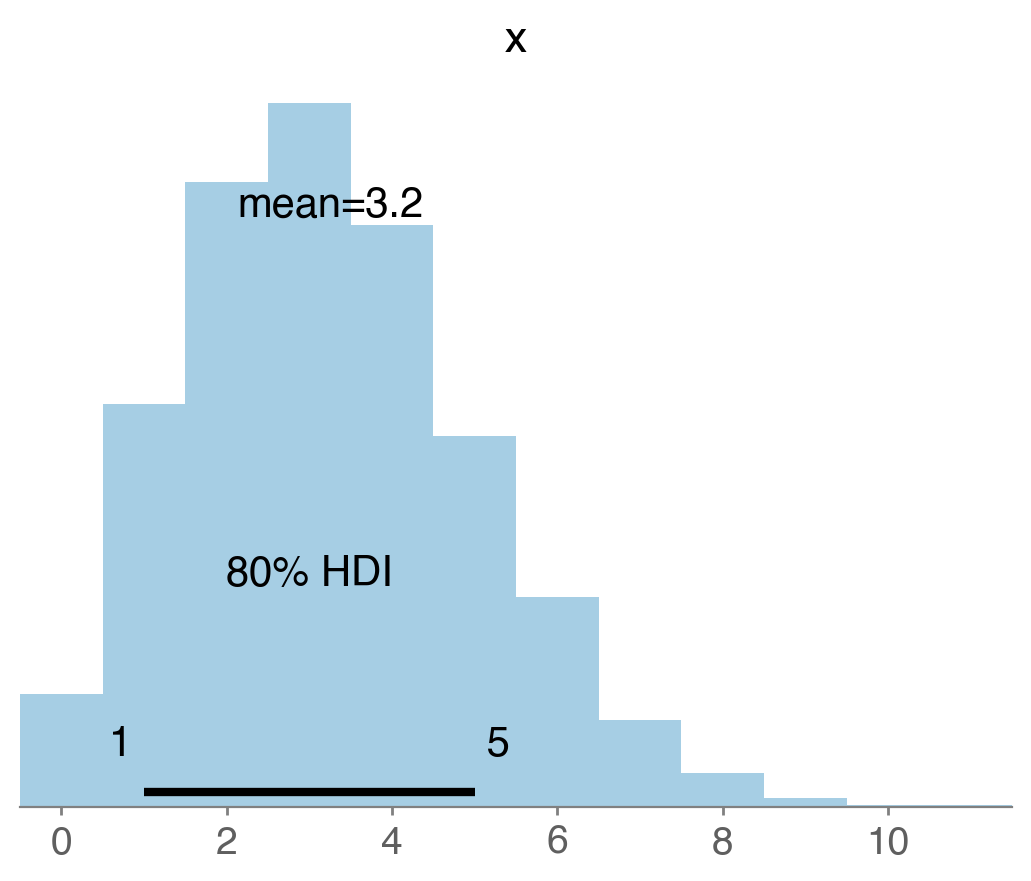

In [48]:
az.plot_posterior(y_rep, hdi_prob=0.8, kind="kde", bw=0.5)
plt.show()

### Posterior predictive checks

La distribuzione predittiva a posteriori è utilizzata per eseguire i *controlli predittivi a posteriori* (PPC), noti come *Posterior Predictive Checks*. I PPC consistono in un confronto grafico tra $p(y^{rep} \mid y)$, ossia la distribuzione delle osservazioni future previste, e i dati osservati $y$. Questo confronto visivo permette di valutare se il modello utilizzato è adeguato per descrivere le proprietà dei dati osservati.

Oltre al confronto grafico tra le distribuzioni $p(y)$ e $p(y^{rep})$, è possibile effettuare un confronto tra le distribuzioni di varie statistiche descrittive calcolate su diversi campioni $y^{rep}$ e le corrispondenti statistiche calcolate sui dati osservati. Tipicamente, vengono considerate statistiche descrittive come la media, la varianza, la deviazione standard, il minimo o il massimo, ma è possibile confrontare qualsiasi altra statistica rilevante.

I controlli predittivi a posteriori offrono un valido strumento per un'analisi critica delle prestazioni del modello e, se necessario, per apportare eventuali modifiche o considerare modelli alternativi più adatti ai dati in esame.

## Distribuzione predittiva a priori

Nella sezione precedente, abbiamo esaminato come la distribuzione predittiva venga utilizzata in analisi bayesiana per rappresentare l'incertezza riguardo alla distribuzione delle future osservazioni di dati. La distribuzione predittiva prende in considerazione sia la distribuzione a posteriori del parametro $\theta$ che la scelta del modello basata sui dati osservati.

Un concetto correlato ma distinto è la *distribuzione predittiva a priori*, che descrive le aspettative sulle future osservazioni del modello prima di avere qualsiasi dato osservato. Questa distribuzione è data dall'equazione:

$$p(y) = \int p(y | \theta) p(\theta) d\theta,$$

dove:
- $p(y | \theta)$ rappresenta la verosimiglianza, ovvero come i dati dipendono dai parametri.
- $p(\theta)$ è la distribuzione a priori dei parametri, che esprime le nostre credenze iniziali riguardo ai valori dei parametri.

Se i dati osservati non sono coerenti con la distribuzione predittiva a priori, significa che il modello bayesiano (la distribuzione a priori, il meccanismo generatore dei dati, o entrambi) potrebbe essere specificato in modo errato. In pratica, questo suggerisce che, secondo il modello bayesiano formulato, i dati effettivamente osservati sono improbabili, e questo potrebbe indicare che il modello è inadeguato.

La distribuzione predittiva a priori è utile per vari motivi:
- **esplorazione delle credenze iniziali**: si può esplorare come le credenze iniziali sui parametri (ad esempio, la probabilità di testa nel lancio di una moneta) si traducano in aspettative concrete sugli esiti osservabili.
- **confronto con i dati reali**: confrontando i dati osservati con la distribuzione predittiva a priori, si può valutare se il modello e le credenze a priori sono adeguati.
- **analisi della sensibilità**: la distribuzione predittiva a priori può anche mostrare quanto le conclusioni del modello siano sensibili a diverse scelte della distribuzione a priori.

La distribuzione predittiva a priori può essere ottenuta usando metodi MCMC, replicando la procedura per la distribuzione predittiva a posteriori, ma senza i dati osservati.

Nell'esempio con i dati di {cite:t}`zetsche_2019future`, se avessimo scelto una distribuzione Beta(2, 10) come a priori, l'analisi predittiva a priori avrebbe potuto rivelare che questa scelta non era adeguata per i dati considerati. Questo esempio dimostra come la distribuzione predittiva a priori possa servire come potente strumento diagnostico nell'analisi bayesiana, aiutando a guidare e rifinire le scelte del modello.

Ritorniamo all'esempio con i dati degli artisti della generazione X al MOMA. Per questi dati abbiamo scelto una distribuzione a priori Beta(4, 6) per il parametro di successo $\theta$. 

In [52]:
print(alpha_prior, beta_prior)

4 6


Eseguiamo l'analisi predittiva a priori con `sample_prior_predictive`.

In [53]:
with model:
    idata_prior_pred = pm.sample_prior_predictive()

Sampling: [obs, theta]


Esaminiamo l'oggetto `idata_prior_pred` che abbiamo creato.

In [54]:
idata_prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

I dati (sulla scala delle osservazioni $y$) sono contenuti in `idata.prior_predictive.obs`. Possiamo usare `arviz` per generare un istogramma della distribuzione predittiva a priori usando la funzione `plot_posterior`:

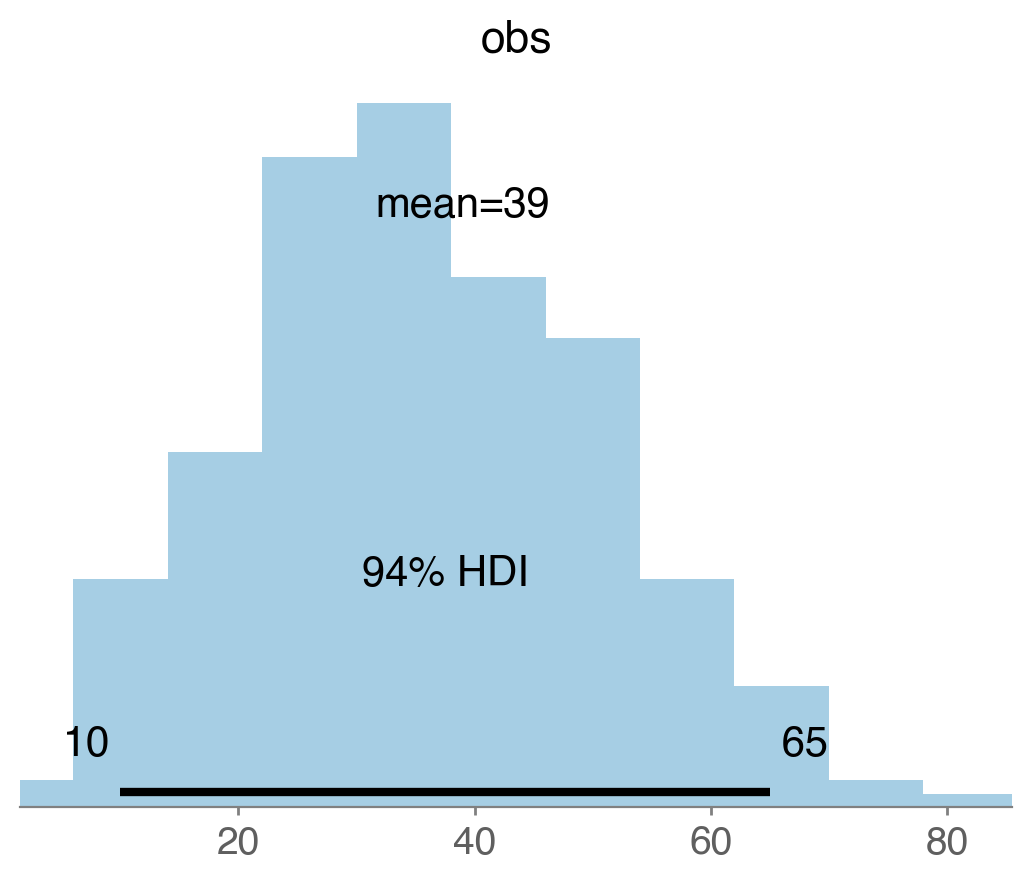

In [55]:
az.plot_posterior(idata_prior_pred.prior_predictive.obs)
plt.show()

La regione dell'intervallo di credibilità ad alta densità (HDI) al 94% è [9, 67]. Nel nostro campione, abbiamo osservato un valore di $y$ = 14. Poiché questo risultato rientra nell'intervallo di credibilità della distribuzione predittiva a priori, possiamo dedurre che la scelta di una distribuzione Beta(4, 6) come distribuzione a priori sembra essere adeguata per i dati in questione.

## Watermark

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Thu Aug 17 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

matplotlib: 3.7.2
arviz     : 0.16.1
scipy     : 1.11.1
pymc      : 5.7.2
numpy     : 1.25.2
pandas    : 2.0.3

Watermark: 2.4.3

